# study segment predictions

In [635]:
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
from PIL import Image

import sys
sys.path.append('../')
from data import load_data

### decile colours

In [636]:
pink = np.array([
[255,255,255],
[247,244,249],
[231,225,239],
[212,185,218],
[201,148,199],
[223,101,176],
[231,41,138],
[206,18,86],
[152,0,67],
[103,0,31]])

magenta = np.array([
[255,255,255],
[255,247,243],
[253,224,221],
[252,197,192],
[250,159,181],
[247,104,161],
[221,52,151],
[174,1,126],
[122,1,119],
[73,0,106]])

green = np.array([
[255,255,255],
[255,255,229],
[247,252,185],
[217,240,163],
[173,221,142],
[120,198,121],
[65,171,93],
[35,132,67],
[0,104,55],
[0,69,41]])

blue = np.array([
[255,255,255],
[255,255,217],
[237,248,177],
[199,233,180],
[127,205,187],
[65,182,196],
[29,145,192],
[34,94,168],
[37,52,148],
[8,29,88]])

brown = np.array([
[255,255,255],
[255,255,229],
[255,247,188],
[254,227,145],
[254,196,79],
[254,153,41],
[236,112,20],
[204,76,2],
[153,52,4],
[102,37,6]])

red = np.array([
[255,255,255],
[255,255,204],
[255,237,160],
[254,217,118],
[254,178,76],
[253,141,60],
[252,78,42],
[227,26,28],
[189,0,38],
[128,0,38]])

black = np.array([
[255,255,255],
[245,245,245],
[240,240,240],
[217,217,217],
[189,189,189],
[150,150,150],
[115,115,115],
[82,82,82],
[37,37,37],
[0,0,0]])

class_colours = np.array([
    [255,255,255], # white: background/unlabeled
    [152,78,163],  # purple: residential
    [55,126,184],  # blue: commercial
    [255,255,51],  # yellow: industrial
    [77,175,74],   # green: vegetation
    [228,26,28],   # red: building
    [166,86,40]    # brown: brownfield
])

In [637]:
hdf5 = h5py.File("../predictions.hdf5")

In [638]:
predictions = hdf5.get("predictions")[()]
predictions.shape

(100, 65536, 7)

In [639]:
#instance = 9 # trees + green building
#instance = 1 # forest
#instance = 11
#instance = 14
#instance = 15
#instance = 26
instance = 30 # industrial (good example)
#instance = 31
#instance = 87 # nice mix of trees + building
#instance = 90 # nice building outline
#instance = 97
prediction = predictions[instance]
prediction.shape

(65536, 7)

In [640]:
class_prediction = prediction[:,2]
class_prediction.shape

(65536,)

## individual class heatmap

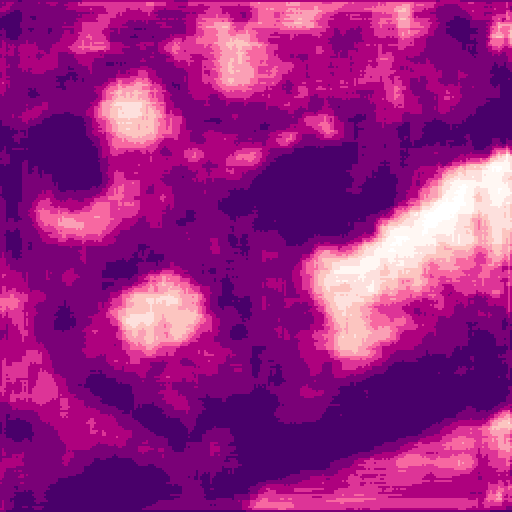

In [661]:
def class_heatmap(heat_deciles, pixel_probabilities, height, width, invert=False, ignore_cut_off=-1, bg_alpha=0, fg_alpha=255):
    bins = np.floor(pixel_probabilities* 10) # discretise
    bins = bins.astype("uint8")
    heat = heat_deciles[::-1] if invert else heat_deciles
    img_arr = np.reshape(heat[bins], (height, width, 3))
    img_arr = img_arr.astype("uint8")
    img = Image.fromarray(img_arr)
    img = img.convert("RGBA")
    # ignore alpha
    img_arr = np.array(img)
    cut_out = np.reshape(bins, (height, width)) <= ignore_cut_off
    img_arr[cut_out, 3] = bg_alpha
    # fg alpha
    img_arr[np.logical_not(cut_out), 3] = fg_alpha
    img = Image.fromarray(img_arr)
    return img

class_heatmap(magenta, prediction[:, 5], 256, 256, True).resize((512, 512))

## segments

In [642]:
def segment(prediction):
    """assign class labels to pixels according to class probabilities.
    
    for each pixel, max(class_prob).
    
    returns an array. len = num pixels.
    """
    pixel_class = np.apply_along_axis(np.argmax, 1, prediction)
    return pixel_class.astype("uint8")

In [643]:
# test
two_pixels_3_classes = np.array([[0.2, 0.3, 0.9], 
                                 [0.1, 0.6, 0.4]])

assert np.alltrue(segment(two_pixels_3_classes) == [2, 1])

In [644]:
def segment_image(pixel_classes, height, width, bg_alpha=0, fg_alpha=255):
    """visualise pixel classes"""
    segment_colours = np.reshape(class_colours[pixel_classes], (height, width, 3))
    segment_colours = segment_colours.astype("uint8")
    img = Image.fromarray(segment_colours)
    # set backgroud/unlabeled pixel alpha to 0.
    # note to self: do with numpy
    img = img.convert("RGBA")
    arr = np.array(img)
    arr = np.reshape(arr, (height*width, 4))
    background = np.where(pixel_classes == 0)
    arr[background, 3] = bg_alpha
    background = np.where(pixel_classes > 0)
    arr[background, 3] = fg_alpha
    arr = np.reshape(arr, (height, width, 4))
    return Image.fromarray(arr)

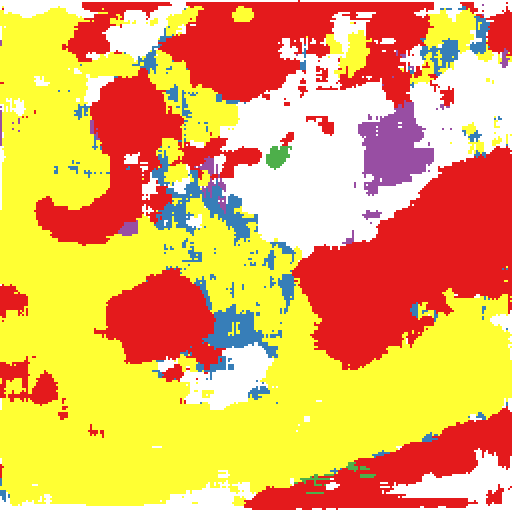

In [645]:
segmented_image = segment_image(segment(prediction), height=256, width=256)
segmented_image.resize((512, 512))

## segment overlay

In [646]:
def combine_image(label_img, sat_img, alpha=128):
    """
    combine 2 images.
    """
    assert label_img.mode == "RGBA"
    #label_arr = np.array(label_img)
    #labeled = np.where(label_arr[:,:,3] != 0)
    #label_arr[labeled, 3] = alpha
    # else set 'alpha'
    #label_arr[np.logical_not(black), 3] = alpha
    #label_img = Image.fromarray(label_arr, "RGBA")
    # combine
    combined_img = sat_img.copy()
    combined_img.paste(label_img, (0, 0), label_img)
    return combined_img

In [647]:
# original test images and labels
images, labels = load_data(skynet_data="../../skynet-data/data", filtered="test-sample-filtered.txt", hdf5_data="../data/testing.hdf5")

Loading data from HDF5.


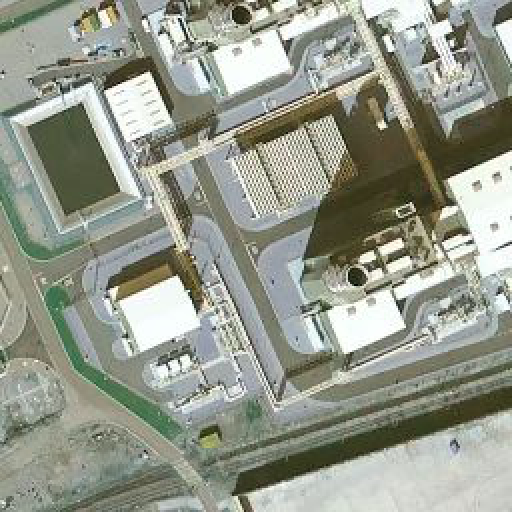

In [648]:
def instance_to_image(instance):
    instance_arr = instance*255 #denormalise
    instance_arr = np.rollaxis(instance_arr, axis=0, start=3)
    instance_arr = instance_arr.astype("uint8")
    return Image.fromarray(instance_arr)

instance_to_image(images[instance]).resize((512, 512))

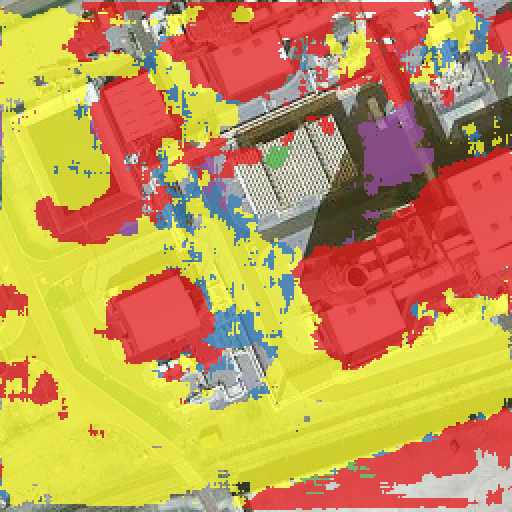

In [649]:
input_image = instance_to_image(images[instance].copy())
segmented_image = segment_image(segment(prediction), height=256, width=256, bg_alpha=0, fg_alpha=192)
combined_image = combine_image(segmented_image, input_image)
combined_image.resize((512, 512))

In [650]:
label_arr = np.array(segmented_image)
labeled = np.where(label_arr[:,:,3] != 0)
label_arr[labeled, 3]

array([[[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ..., 
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[228,  26,  28, 192],
        [255, 255,  51, 192],
        [255, 255,  51, 192],
        ..., 
        [255, 255,  51, 192],
        [255, 255,  51, 192],
        [255, 255,  51, 192]]], dtype=uint8)

## segment heatmap overlay

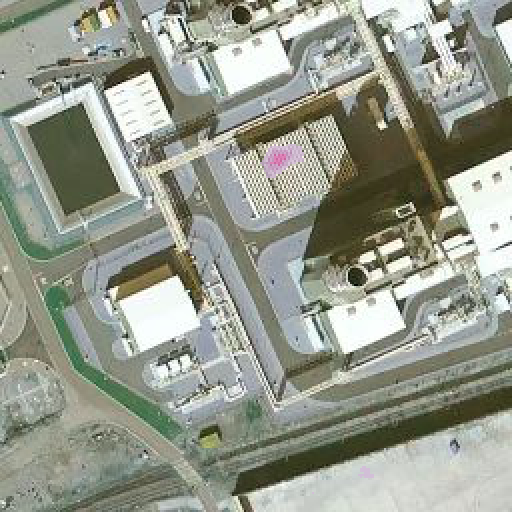

In [651]:
segment_heatmap = class_heatmap(pink, prediction[:, 4], 256, 256, invert=False, ignore_cut_off=2, fg_alpha=192)
combined_image = combine_image(segment_heatmap, input_image)
combined_image.resize((512, 512))

## multple heatmap overlay

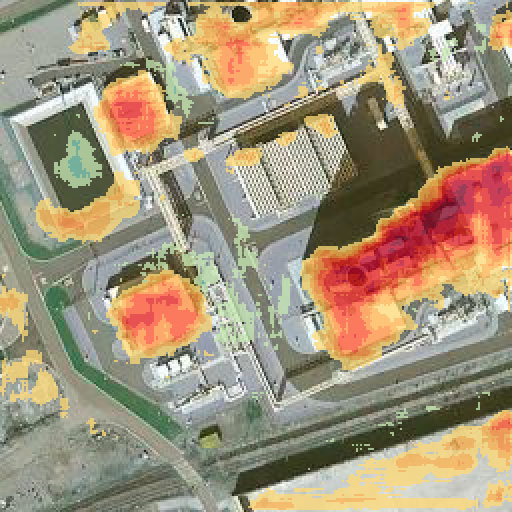

In [652]:
segment_heatmap = class_heatmap(blue, prediction[:, 2], 256, 256, invert=False, ignore_cut_off=2, fg_alpha=192)
combined_image = combine_image(segment_heatmap, input_image)

segment_heatmap = class_heatmap(red, prediction[:, 5], 256, 256, invert=False, ignore_cut_off=2, fg_alpha=192)
combined_image.paste(segment_heatmap, (0, 0), segment_heatmap)

combined_image.resize((512, 512))

## summarise all

input image, overlaid ground truth, overlaid segments, overlaid segment heatmap

(note, this is broken. can not get matplotlib to plot more than 4 rows of images before it starts inserting vertical weight space and resizing images...)

In [653]:
def plot_images(images, rows, cols):
    coords = itertools.product(range(0, rows), range(0, cols))
    
    #f = plt.figure(figsize=(16,16))
    #axarr = [f.add_subplot(rows, cols, i+1) for i in range(rows*cols)]
    
    plt.figure(figsize = (16, 16))
    gs = gridspec.GridSpec(rows, cols,width_ratios=[1, 1, 1], wspace=0.0, hspace=0.0, 
                           top=0.95, bottom=0.05, left=0.17, right=0.845)
    
    for g, img in zip(gs, images):
        a = plt.subplot(g)
        plt.axis("off")
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.set_aspect("equal")
        a.imshow(np.asarray(img))
        
    plt.show()
    

    #f, axarr = plt.subplots(rows, cols, figsize=(16, 16))
    
    #for img in images:
        #x, y = next(coords)
        #a = axarr[x, y]
     
    #for a, img in zip(axarr, images):
    #    a.set_xticklabels([])
    #    a.set_yticklabels([])
    #    #a.set_aspect("equal")
    #    a.imshow(np.asarray(img))
    
    #f.subplots_adjust(hspace=0, wspace=0)
    

In [654]:
def plain_combo(image, prediction):
    input_image = instance_to_image(image.copy())
    segmented_image = segment_image(segment(prediction), height=256, width=256, bg_alpha=0, fg_alpha=192)
    return combine_image(segmented_image, input_image)

if False:
    a = [instance_to_image(x) for x in images]
    b = [segment_image(segment(x), height=256, width=256) for x in labels]
    c = [plain_combo(x, y) for x, y in zip(images, predictions)]


In [655]:
if False:
    to_plot = [x for y in zip(a, b, c) for x in y]
    plot_images(to_plot[0:12], 4, 3)

## test subset summary

for each instance, show:

* segment %s > 0 / detected in scene.
* confusion matrix.
* tp, tn, fp, fn, precision, recall, accuracy.

for entire test, show:

* confusion matrix et. al.